# Environment Configuration

In [1]:
## init all the necessary models
# !rm -rf *

# !gdown https://drive.google.com/uc?id=1r6QD7lEM6UTMbnoxEQqTsK0k0B8XziC1
# !gdown https://drive.google.com/uc?id=1rEIWWLwEpbZGPyFUc9jSIQr78ZeQy5eZ
# !unzip srdplus-pretrained.zip && rm srdplus-pretrained.zip

# !git clone  https://github.com/vinthony/ghost-free-shadow-removal
# !cp ghost-free-shadow-removal/networks.py .

vgg19_path = 'imagenet-vgg-verydeep-19.mat'
pretrain_model_path = 'srdplus-pretrained/'
sample_path = 'ghost-free-shadow-removal/Samples'

# Loading Pre-trained Model

In [2]:
# loaded pretrained model and build the calculate graph
# %matplotlib inline
# %tensorflow_version 1.x 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from networks import build_aggasatt_joint

with tf.variable_scope(tf.get_variable_scope()):
    input=tf.placeholder(tf.float32,shape=[None,None,None,3])
    shadow_free_image=build_aggasatt_joint(input,64,vgg19_path)

sess=tf.Session()
sess.run(tf.global_variables_initializer())
idtd_ckpt=tf.train.get_checkpoint_state(pretrain_model_path)
saver_restore=tf.train.Saver([var for var in tf.trainable_variables()])
print('loaded '+idtd_ckpt.model_checkpoint_path)
saver_restore.restore(sess,idtd_ckpt.model_checkpoint_path)

c:\users\97254\anaconda3\envs\hackathon2\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\97254\anaconda3\envs\hackathon2\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\97254\anaconda3\envs\hackathon2\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\97254\anaconda3\envs\hackathon2\lib\site-packages

[i] Hypercolumn ON, building hypercolumn features ... 
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.average_pooling2d instead.
loaded srdplus-pretrained/model_best.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from srdplus-pretrained/model_best.ckpt


# Evaluation on SRD dataset

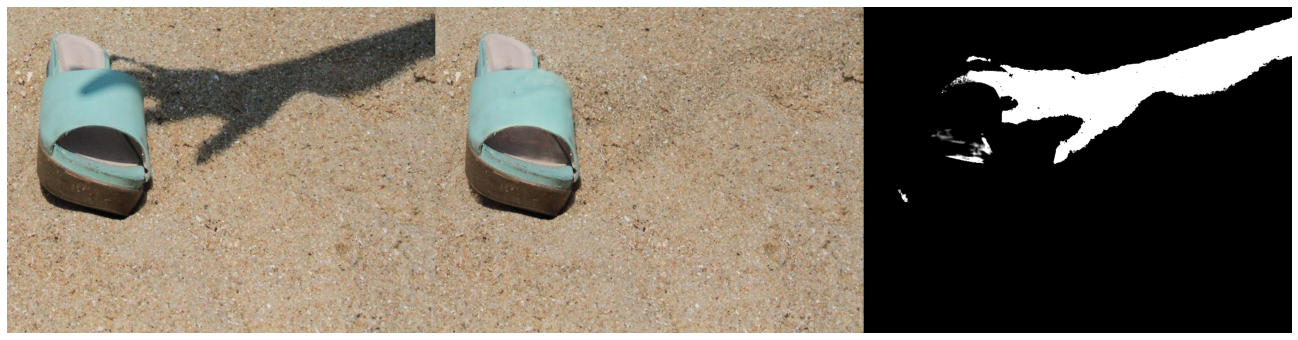

KeyboardInterrupt: ignored

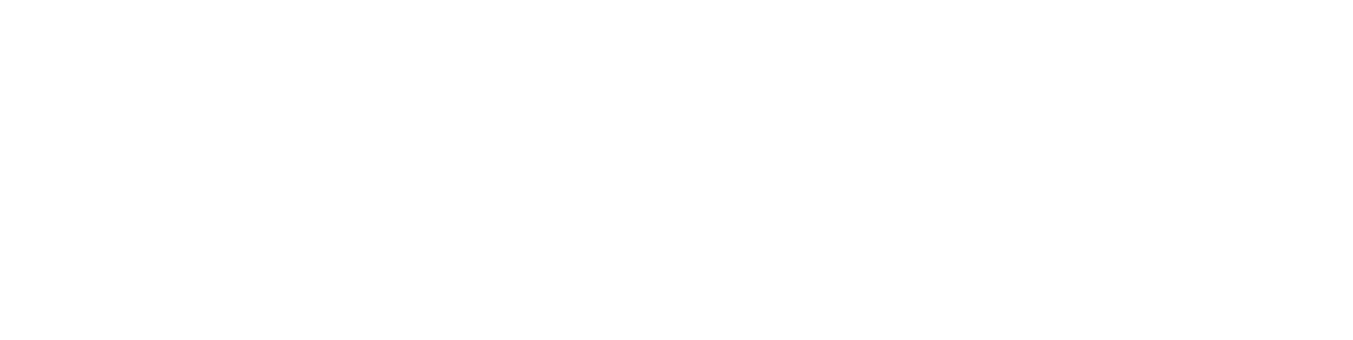

In [ ]:
import os,cv2
# some samples results.
plt.rcParams["figure.figsize"] = (24,6)
sample_path = 'Samples'
for img_path in [os.path.join(sample_path,x) for x in os.listdir(sample_path) if '.jpg' in x ]:

    plt.figure()
    plt.axis('off')
    
    iminput=cv2.imread(img_path,-1)
    imoutput = sess.run(shadow_free_image,feed_dict={input:np.expand_dims(iminput/255.,axis=0)})

    ## imoutput[0] means the shadow removal results while imoutput[1] means the shadow detection results.
    imremoval = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[0],0.0),1.0))*255.0)
    immask = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[1],0.0),1.0))*255.0)
    imcompare = np.concatenate([iminput,imremoval,np.repeat(np.expand_dims(immask,axis=2),3,2)],axis=1)

    # bgr->rgb
    plt.imshow(imcompare[...,::-1])
    plt.show()

In [3]:
import sys

import matplotlib.pyplot as plt
import numpy as np
# from skimage import data, io
# from skimage import exposure
# from skimage.transform import match_histograms
from imutils.perspective import four_point_transform
import cv2

# constants
from get_colour import shepards_interpolation, distance_two_colours
from tamboor import find_closest_colors_on_card, sample_rgb_of_square

from closest_colours import get_closest_colours

# images
ref_card = None
input_card = None

# dims
img_height = 0
img_width = 0
card_height = 11
card_width = 10

# sample hole
sample_idx = (9, 1)
sample_color = 0
num_of_closest_colors = 15

In [4]:
def sample_rgb_of_square(img, square_x, square_y):
    cube_height = img_height / card_height
    cube_width = img_width / card_width
    return img[int((square_x * cube_height) + cube_height / 2),
               int((square_y * cube_width) + cube_width / 2)][::-1]


In [ ]:
# def find_color_card(image):
#     # load the ArUCo dictionary, grab the ArUCo parameters, and
#     # detect the markers in the input image
#     arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_ARUCO_ORIGINAL)
#     arucoParams = cv2.aruco.DetectorParameters_create()
#     (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

#     # try to extract the coordinates of the color correction card
#     try:
#         # otherwise, we've found the four ArUco markers, so we can
#         # continue by flattening the ArUco IDs list
#         ids = ids.flatten()
#         # extract the top-left marker
#         i = np.squeeze(np.where(ids == 923))
#         topLeft = np.squeeze(corners[i])[0]
#         # extract the top-right marker
#         i = np.squeeze(np.where(ids == 1001))
#         topRight = np.squeeze(corners[i])[1]
#         # extract the bottom-right marker
#         i = np.squeeze(np.where(ids == 241))
#         bottomRight = np.squeeze(corners[i])[2]
#         # extract the bottom-left marker
#         i = np.squeeze(np.where(ids == 1007))
#         bottomLeft = np.squeeze(corners[i])[3]
#     # we could not find color correction card, so gracefully return
#     except:
#         print("[INFO] could not find color matching card in both images")
#         sys.exit(0)

#     # build our list of reference points and apply a perspective
#     # transform to obtain a top-down, bird’s-eye view of the color
#     # matching card
#     cardCoords = np.array([topLeft, topRight,
#                            bottomRight, bottomLeft])
#     card = four_point_transform(image, cardCoords)
#     # return the color matching card to the calling function
#     return card


In [5]:
def find_closest_colors_on_card():
    colors_distances = {}
    for row in range(1, card_height - 2):
        for col in range(1, card_width - 1):
            current_color = sample_rgb_of_square(input_card, row, col)
            # TODO change distance formula
            # distance = np.subtract(sample_color, current_color)
            # distance_abs = np.absolute(distance)
            # distance_num = np.sum(distance_abs)
            distance_between_colors = distance_two_colours(sample_color, current_color)
            distance_num = np.sum(distance_between_colors)
            colors_distances[f"{row},{col}"] = (current_color, distance_num)

    return sorted(colors_distances.items(), key=lambda kv: kv[1][1])[:num_of_closest_colors]


In [ ]:
# import sys

# import matplotlib.pyplot as plt
# import numpy as np
# # from skimage import data, io
# # from skimage import exposure
# # from skimage.transform import match_histograms
# from imutils.perspective import four_point_transform
# import cv2

# # constants
# from get_colour import shepards_interpolation, distance_two_colours
# from tamboor import find_closest_colors_on_card, sample_rgb_of_square
# from get_colour import shepards_interpolation
# # images
# ref_card = None
# input_card = None

# # dims
# img_height = 0
# img_width = 0
# card_height = 11
# card_width = 10

# # sample hole
# sample_idx = (9, 1)
# sample_color = 0
# num_of_closest_colors = 15

img_path = 'tests/real photo 4.png'
iminput=cv2.imread(img_path)
imS = cv2.resize(iminput, (500, 550)) 

imoutput = sess.run(shadow_free_image,feed_dict={input:np.expand_dims(imS/255.,axis=0)})

## imoutput[0] means the shadow removal results while imoutput[1] means the shadow detection results.
imremoval = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[0],0.0),1.0))*255.0)

# load images
# input_img = cv2.imread("tests\\0021p-noise.png")
reference_img = cv2.imread("tests\\ref.png")
# TODO add markers support
# input_card = find_color_card(input_img)
# reference_card = find_color_card(reference_img)
input_card = imremoval
reference_card = reference_img

# image resize
# print('Original Dimensions : ', input_card.shape)
scale_percent = 100  # percent of original size
img_width = int(input_card.shape[1] * scale_percent / 100)
img_height = int(input_card.shape[0] * scale_percent / 100)
dim = (img_width, img_height)

# resize image
input_card = cv2.resize(input_card, dim, interpolation=cv2.INTER_AREA)
input_card = cv2.GaussianBlur(input_card,(5,5),0)
# print('Resized Dimensions : ', input_card.shape)

wb = cv2.xphoto.createGrayworldWB()

# cv2.imshow("Input Color Card", input_card)
# cv2.waitKey(0)

    # white balance
wb.setSaturationThreshold(0.99)
input_card = wb.balanceWhite(input_card)
    # print('Resized Dimensions : ', input_card.shape)
# get sampled color
sample_color = sample_rgb_of_square(input_card, sample_idx[0], sample_idx[1])
print('sampled color: ', sample_color)

# prepare lists for ARYEH
input_closest_colors = []
target_closest_colors = []
indices_and_rgbs = (find_closest_colors_on_card())
for index_rgb in indices_and_rgbs:
    input_closest_colors.append(index_rgb[1][0])
    # extract coords from key
    x = index_rgb[0].split(sep=',')[0]
    y = index_rgb[0].split(sep=',')[1]
    rgb_color = sample_rgb_of_square(reference_card, int(x), int(y))
    target_closest_colors.append(rgb_color)
input_closest_colors = np.array(input_closest_colors)
target_closest_colors = np.array(target_closest_colors)

# print(f"input {input_closest_colors}")
# print(f"target {target_closest_colors}")

delta = np.array([1,2,3])

delta = shepards_interpolation(input_closest_colors, target_closest_colors, sample_color)

# calculate new color RGB
new_color = np.add(sample_color, delta)
print("the change in the colour for all channels are:" + str(delta) + "\n")

closest_colours = get_closest_colours(new_color)
print("the five closest tamboor colours are:")
print(f"{closest_colours['RGB']}")
cv2.imshow("Input Color Card", input_card)
cv2.waitKey(0)

sampled color:  [ 74 134 146]
the change in the colour for all channels are:[11.85043798439939, 21.0, -0.8896257675594076]

the five closest tamboor colours are:
961     [95, 148, 147]
1164    [93, 146, 153]
954     [97, 148, 140]
899     [78, 154, 133]
906     [66, 155, 144]
Name: RGB, dtype: object


# Test samples from web

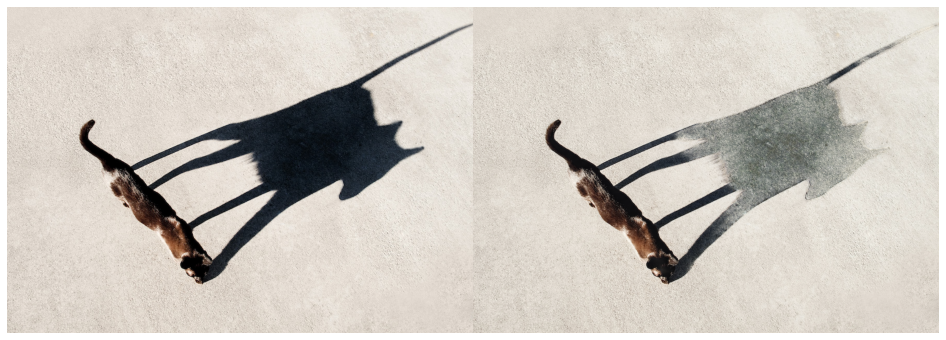

In [ ]:
# get image from web.
import requests
from io import BytesIO
from PIL import Image

plt.rcParams["figure.figsize"] = (24,6)
# images from google photo
# [you can replace the url with our own data for testing!]
urls = [
'https://mymodernmet.com/wp/wp-content/uploads/2017/04/shadow-photography-tips-16.jpg'
]

for url in urls:
  r = requests.get(url)
  # pil->numpy->bgr
  iminput = np.asarray(Image.open(BytesIO(r.content)))[...,::-1]
  imoutput = sess.run(shadow_free_image,feed_dict={input:np.expand_dims(iminput/255.,axis=0)})

  plt.figure()
  plt.axis('off')
  imoutput = np.uint8(np.squeeze(np.minimum(np.maximum(imoutput[0],0.0),1.0))*255.0)
  imcompare = np.concatenate([iminput,imoutput],axis=1)
  # bgr->rgb
  plt.imshow(imcompare[...,::-1])
  plt.show()